# Assignment - Data Collection, preprocessing and analysis


**Name** - *Chirag Shah*  
**Enrollment Number** - *19200072*

In [356]:
#lots of imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import stats
from dateutil.parser import parse
import warnings, os, time, requests
from pathlib import Path
from glob import glob
import folium
from folium import plugins
warnings.filterwarnings('ignore')
%matplotlib inline

## Task  1: Identify one or more suitable web APIs¶

<strong><h3>New York Crime Data Analysis.</h3></strong>
* New York is the most popular city in United States of America(USA). It has a population of more than 8.5 million and it keeps growing. Being densely populated city has direct impact on crime rate. However, the crimes in city are unevenly distributed depending on various factors. Once known as the "murder capital", NYC crime, especially murder rates, has decreased in that last two decades. However, crime has not stopped, so it's important to know when, where, and what crimes are taking place. It is especially important to know what kind of crimes happen where. Thus, we're going to embark on an exploratory data analysis of crime complaints in NYC and make predictions about crimes in Brooklyn.

* New York has 5 administrative regions called Boroughs := `['The Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island']`
* <b>Objectives</b> - 
    * To understand crime rate in New York in the last 6 years (2013 - 2019).
    * What kind of crimes are most prevalent in New York?
    * Are there certain times when crime is more likely to occur? If so, when?
    * Find if there is any major difference in the regions of New York in crime rate.
    * Try to find associations / patterns in crime analysis with respect to another important criteria in New York.
    
* <b>Data Sources</b> -
    * The data for this analysis is taken from two sources namely - 
        - [NYPD Complaint Data Historic](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i)
           : This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2017 
        - [NYPD Complaint Data Year To Date](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243)
           : This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) for all complete quarters so far from 2018 to 2019
        
    * Both the datasets belong to the New York Crime Department. This dataset is publicly avaiable via the Socrata Open Data API. More about the Socrata Open Data API can be found [here](https://dev.socrata.com/)
    

* <b>Note on limitations</b> - 
    1. Historic data has been collected from 2013 to 2017. For each year 6 months data has been collected from January to June
    2. Year to Date data has been collected from 2018 to 2019. For each year 6 months data has been collected from January to June
    3. Manually change dates in the scraping utility to get data

## Task 2: Collect data from chosen API(s)¶

### Set default configuration variables that can be used globally

1. `setDefaults()` : acts as setter function that initialises global variables which can be referenced throughout the notebook 
2. `isValid()` : validation checks to check if the request parameters and other globals are passed correctly to the API  
3. `isValidAndSetDefaults()` : helper function for setDefaults() and isValid()

In [357]:
vars_ = {key : None for key in ['APP_TOKEN', 'LIMIT', 'DATASET', 'BASE_URL', 'URI_IDENTIFIERS', 'SAVE_TO_DIRECTORY', \
                                                                 'START_DATE', 'END_DATE', 'RES_PER_RESPONSE']}

def setDefaults(dataset, start_date, end_date, save_to_directory, results_per_response=10000, limit=100000):
    '''
    Setters for default configuration vars required in data collection process
    '''
    global vars_
    vars_['APP_TOKEN'] = "jlyZazYtAq9hSQNf0Ow4pNySj"
    vars_['LIMIT'] = limit
    vars_['DATASET'] = dataset
    vars_['BASE_URL'] = "https://data.cityofnewyork.us/resource/"
    vars_['URI_IDENTIFIERS'] = ['5uac-w243', 'qgea-i56i']
    vars_['START_DATE'] = start_date
    vars_['END_DATE'] = end_date
    vars_['RES_PER_RESPONSE'] = results_per_response
    vars_['SAVE_FILE_ENDING'] = 'Historic' if vars_['DATASET'] == 'qgea-i56i' else 'YTD'
    vars_['SAVE_TO_DIRECTORY'] = save_to_directory + '_' + vars_['SAVE_FILE_ENDING']
    
    
    if all(map(lambda x: x is not None, vars_.values())):
         print("Log: Defaults successfully loaded.")
    else:
         print("Log: Some defaults weren't loaded correctly.")

def isValid(dataset, start_date, end_date, save_to_directory, results_per_response=10000, limit=100000):
    '''
    Performs validation checks on the input from user
    @params:
    data_uri := uniform resource identifier associated with the data to scrape from the API
    data_sz := limit / dataset size to scrape

    @return:
    #need to reframe this..
        1. [If dataset == none || data_sz  != int || data_sz != +ve int || (start_date && end_date) != datettime] := returns -1
        2. [If data_sz == none := returns 0 and sets default results_per_responsee = 1000
        3. [Everything works perfect := returns 1] 
    '''
    
    global vars_  
    def validDate(date): #util for date validation
         try: 
            parse(date, fuzzy=True)
            print("Correct date")
            return True
         except ValueError:
            print("Error: Incorrect date.")
            return False

    if dataset is None: #dataset uri is empty
        print("Error: Invalid URI.")
        return -1

    elif results_per_response is None: #limit is empty
        print("Log: Results per response is empty. Setting default as 10000.")
        return 0

    elif start_date is None: #start_date is empty
        print("Error: Start date is empty.")
        return -1
        
    elif end_date is None: #start_date is empty
        print("Error: End date is empty.")
        return -1
         
    elif save_to_directory is None: #savetodirectory is empty
        print("Error: Directory to write data is not present.")
        return -1
    
    elif results_per_response is None: #max limit is empty
        print("Log: Results per response is empty. Setting default as 10000.")
        return 0
    
    elif limit is None: #max limit is empty
        print("Log: Default limit is empty. Setting default as 100000.")
        return 0
         
    elif dataset and start_date and end_date:  #params aren't empty
        #performing validation checks on data 
        try: 
            results_per_response = int(results_per_response) #check if results_per_response is !<= 0
            if results_per_response <= 0:
                print("Error: Specifid results per response is not > 0.")
                return -1
        except ValueError:
            print("Error: Not an integer.")
            return -1
        
        try: 
            limit = int(limit) #check if limit is !<= 0
            if limit <= 0:
                print("Error: Specifid results per response is not > 0.")
                return -1
        except ValueError:
            print("Error: Not an integer.")
            return -1

        if validDate(start_date) != True: #start_date is invalid
            return -1

        if validDate(end_date) != True: #end_date is invalid
            return -1

        parts = str(dataset).split('-') #check if dataset_uri length is perfect
        if len(parts[0]) != 4 or len(parts[1]) != 4:
            print("Error: Invalid URI.")
            return -1

        #Some cheating here... hardcoding values for validation checks
        if dataset not in {'5uac-w243','qgea-i56i'}: #check if its the right dataset_uri
            print("Error: Invalid Dataset URI.")
            return -1
        
        p1 = Path(os.getcwd() + '\data_Historic')
        p2 = Path(os.getcwd() + '\data_YTD')
        
        if not p1.exists():
            print(str(p1))
            print("Error: Path to save csv files for Historic data doesn't exist.")
            return -1
        
        if not p2.exists():
            print(str(p2))
            print("Error: Path to save csv files for Year To Date data doesn't exist.")
            return -1

        
        print("Log: Validations passed.")
        return 1

def isValidAndSetDefaults(dataset_uri, start_date, end_date, save_to_directory, results_per_response=10000, limit=100000):
    '''
    check if everything isvalid and defaults are loaded
    @return: boolean variable True or False
    @params:
    dataset_uri := uniform resource identifier associated with the data to scrape from the API
    start_date := date to start scraping the dataset from
    end_date := date to end scraping the dataset from
    save_to_directory := target location where the csvs are to be stored
    results_per_responses := number of records to scrape per API request
    limit := max limit on number of records to scrape globally
    '''
    
    ret_value = isValid(dataset_uri, start_date, end_date, save_to_directory)
    if ret_value == -1: #something isn't working correctly. Check logs
        print("Error: Unable to set defaults.")
        return False
    elif ret_value == 0: #everything is working correctly, except no default params specified in the data fetch operation.
        setDefaults(dataset_uri, start_date, end_date, save_to_directory)
        return True     
    elif ret_value == 1:
        setDefaults(dataset_uri, start_date, end_date, save_to_directory, results_per_response, limit)
        return True
    else:
        print("Error: Unknown error.")
        return False

### Perform API Request and store the response in csv file

1. `getData()`: helper function to support the below operations  
    1.1 `buildURL()` : constructs URL from base URL and global vars_  
    1.2 `callAPI()` :  helper function that performs data fetch operation  
    1.3 `getDataByChunks()` : main function that builds the data by fetching it in chunks and dumping into the csv files  
2. `mergeCSV()`: merges the resultant csv files obtained from getData() to a single resultant csv file  

In [358]:
def getData():
    global vars_ #accessing globals
    
    #------------------------#Helpers for the function getData----------------------#  
    def buildURL():
        '''
        Builds complete URL to be used for scraping
        @return: returns complete url to use for scraping
        ''' 
        url = str(vars_['BASE_URL'] + vars_['DATASET']) + ".json?$where=cmplnt_fr_dt >='{}' and cmplnt_fr_dt < '{}'&$limit={}&$order=cmplnt_fr_dt".format(vars_['START_DATE'], vars_['END_DATE'], vars_['RES_PER_RESPONSE'])
        print(url)
        return url

    def callAPI(url):
        '''
        Performs API request to get data with appropriate token and receives response
        @params: complete URL
        @return: If response_code == 200 := json dump of received response, else None 
        '''
        token = vars_['APP_TOKEN'] #get the APP_TOKEN defined in the vars_
        header = {"X-App-Token": token} #pass the APP_Token as the header in the request
        res = requests.get(url, headers = header, verify = False) #perform actual get operation of request
        print(f"HTTP response code: {res.status_code}") 
        if (res.status_code == 200):#check for status code
            results = res.json() #parse the request.response to json
            return results
        else:
            return None

    def getDataByChunks():
        '''
        main function that performs data fetch operation in chunks as the data is very huge
        
        '''
        offset = 0
        prevFound = vars_['RES_PER_RESPONSE'] - 1

        while(prevFound > 0):
            url = buildURL()
            url += "&$offset={}".format(offset) #Appending offset to set start of records in dataset
            
            print(f"Calling offset {offset} : {url}")
            results = callAPI(url)

            if (results == None): #if the received response is invalid or has no fetched records
                prevFound = 0
            else:            
                prevFound = len(results)
                print("Results Found:", prevFound)

                if (prevFound > 0):
                    df = pd.io.json.json_normalize(results) #normalise the results from json to dataframe
                    firstDate = df["cmplnt_fr_dt"].head(1) 
                    lastDate = df["cmplnt_fr_dt"].tail(1)
                    print("First Date:", firstDate)
                    print("Last Date:", lastDate)
                    fileName = "NewYork_Crime_" + vars_['START_DATE'] + "_" + vars_['END_DATE'] + "_" + str(offset).zfill(20) + ".csv" #complete filename to store each datachunk
                    print(f"Saving {prevFound} records to fileName: {fileName}")
                    p = Path(os.getcwd() + '\\' + vars_['SAVE_TO_DIRECTORY'] + '\\') #Bad design.. trying to get path on the fly..must be system variable
                    df.to_csv(os.path.join(str(p), fileName), index = False) #parse to csv each file
                    offset = offset + vars_['RES_PER_RESPONSE']
                    time.sleep(5) # to pause for 5 seconds before starting next round of data fetch operation for each datachunk
                    print("--------------------------------------------------------------------------------------------------------")        
    getDataByChunks()
    #-------------------------------------######------------------------------------#

def mergeCSV():
    '''
    Merge multiple csv's generated by getData() from the vars_['SAVE_TO_DIRECTORY'] into single csv
    @return: merged_csv file
    '''
    
    merge_header = "NYPD_Complaint_Data_" #string to use in naming csv filenames while performing writes
    print(f"Current path - {os.getcwd()} + '\\' + {vars_['SAVE_TO_DIRECTORY']} + '\\'")
    path = Path(os.getcwd() + '\\' + vars_['SAVE_TO_DIRECTORY'] + '\\') #i think i need this in global
    all_files = glob(os.path.join(path, "*.csv")) #find all csv files in the path
    concatenated = []
    total_files = len(all_files)
    print(f"Total files - {total_files}") #check total files length and then loop over all the files in the csv
    if total_files > 0: #validation check
        print("Merge started.")
        for filename in all_files:
            df = pd.read_csv(filename, index_col=None, header=0) #parse the file and store it to df
            concatenated.append(df) #store all the dfs in list.
            print(f"Log: loaded file- {filename} in dataframe") #logging for each filename
        frame = pd.concat(concatenated, axis=0, sort = True) #expensive operation for larger datasets
        
        #set frame header to be used as csv filename
        frame_header = merge_header + vars_['SAVE_FILE_ENDING'] + ".csv"
        print(frame_header) #logging for combined dataframe file in the end
        frame.to_csv(frame_header) #parse the final concatenated df to csv 
    else:
        print("Error.")

## Task 3: Parse the collected data, and store it in an appropriate file format¶

### Define entry-point helper function to call getData() on two API endpoints

1. `preprocessData()`: preprocesses data and returns two df respectively for historic and yearToDate  
    1.1 `preprocessHistoric()`:  preprocess data and returns df for historic data  
    1.2 `preprocessYearToDate()`:  preprocess data and returns df for yearToDate data  

<b>Note</b> - 

<b><i>To trigger this API call for 6 years, you have to manually change the dates in the `preprocessHistoric()` and `preprocessYearToDate()`</i></b>

* For `preprocessHistoric`, a sample setup for API request will be as:  

`def preprocessHistoric(dataURI):
        isValidAndSetDefaults(dataURI, <start_date_as_string>, <end_date_as_string>, "data") #This is the line that has to be modified
`
<hr></hr>

* For `preprocessYearToDate`, a sample setup for API request will be as:  

`def preprocessYearToDate(dataURI):
        isValidAndSetDefaults(dataURI, <start_date_as_string>, <end_date_as_string>, "data") #This is the line that has to be modified
`

<b><i>Also, there must be empty directories created with exact name as `data_Historic` and `data_YTD` in the same directory where this notebook exists to ensure that this code runs successfully. Without these directories, the user will not be able to send the API request</i></b>

In [360]:
def preprocessData():
    '''
    Here, I manually changed the dates on every run to get data for 6 months for 6 years from 2013 - 2019
    We can changes
    @return: two dataframes := historic and yearToDate
    '''
    def preprocessHistoric(dataURI):
        '''
        @params:dataURI == 'qgea-i56i'
        Here, the API base endpoint for historic data is https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i 
        '''
        if dataURI is None:
            print("Error: DataURI is missing.")
        print("------------Pre-processing NYPD_Complaint_Data Historic records---------------")
        isValidAndSetDefaults(dataURI, "2018-01-01", "2018-06-30", "data")
        print(f"Default configurations -\n {vars_}")
        getData() # -- comment this code out once its done scraping data
        mergeCSV() # -- comment this code out once a final merged csv is formed in the root folder
        
    def preprocessYearToDate(dataURI):
        '''
        @params:dataURI == '5uac-w243'
        Here, the API base endpoint for yearToDate data is https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/5uac-w243 
        '''
        if dataURI is None:
            print("Error: DataURI is missing.")
        print("------------Pre-processing NYPD_Complaint_Data Year-To-Date records---------------")
        isValidAndSetDefaults(dataURI, "2019-01-01", "2019-06-30", "data")
        print(f"Default configurations -\n {vars_}")
        getData() # -- comment this code out once its done scraping data
        mergeCSV() # -- comment this code out once a final merged csv is formed in the root folder
    
    #comment the next two lines after pulling data from source
    preprocessHistoric("qgea-i56i")
    preprocessYearToDate("5uac-w243")   
    
    df_historic = pd.read_csv("NYPD_Complaint_Data_Historic.csv", index_col=0) #read historic
    df_ytd = pd.read_csv("NYPD_Complaint_Data_YTD.csv", index_col=0) #read ytd 
    return df_historic, df_ytd
    
dfH, dfY = preprocessData()
dfHplusY = pd.concat([dfH, dfY], sort=True) #concatenate both the historic and yearToDate df to get final df.

------------Pre-processing NYPD_Complaint_Data Historic records---------------
Correct date
Correct date
Log: Validations passed.
Log: Defaults successfully loaded.
Default configurations -
 {'APP_TOKEN': 'jlyZazYtAq9hSQNf0Ow4pNySj', 'LIMIT': 100000, 'DATASET': 'qgea-i56i', 'BASE_URL': 'https://data.cityofnewyork.us/resource/', 'URI_IDENTIFIERS': ['5uac-w243', 'qgea-i56i'], 'SAVE_TO_DIRECTORY': 'data_Historic', 'START_DATE': '2018-01-01', 'END_DATE': '2018-01-30', 'RES_PER_RESPONSE': 10000, 'SAVE_FILE_ENDING': 'Historic'}
https://data.cityofnewyork.us/resource/qgea-i56i.json?$where=cmplnt_fr_dt >='2018-01-01' and cmplnt_fr_dt < '2018-01-30'&$limit=10000&$order=cmplnt_fr_dt
Calling offset 0 : https://data.cityofnewyork.us/resource/qgea-i56i.json?$where=cmplnt_fr_dt >='2018-01-01' and cmplnt_fr_dt < '2018-01-30'&$limit=10000&$order=cmplnt_fr_dt&$offset=0
HTTP response code: 200
Results Found: 10000
First Date: 0    2018-01-01T00:00:00.000
Name: cmplnt_fr_dt, dtype: object
Last Date: 9999

Note, the above cell produces a sample API Call for 2 datasets.
1. Historic dataset between date range => ("2018-01-01", "2018-01-30")  
2. Year to date dataset between date range => ("2019-01-01", "2019-01-30")

However, further analysis is been performed on the complete dataset of 6 years

After scraping data of 6 years, following are the dataframe shapes obtained:
1. Historic data shape (dfH) = (1393340, 36)
2. Year To Date data shape (dfY) = (218610, 36)
3. Combined Data shape (dfHplusY) = (1611950, 36)

## Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data¶

### Preprocessing step 1 - Trim the columns that have NAN values > 50 %

In [14]:
def trimNANColumns(dataframe):
    '''
    here we perform various steps of preprocessing
    @params: dataframe
    
    '''
    if dataframe is None: #validation check
        print("Error: No dataframe received.")
        return
    #display(dataframe)
    nans, cols, trim_cols = list(dataframe.isnull().sum()), list(dataframe.columns), list() #list of nan_counts in each column, list of columns
    length_df, width_df = dataframe.shape #get the shape of dataframe
    nans = [int(n) for n in nans] #map the nans to int
    
    print(f"List of NAN counts in columns-\n {nans}\n")
    print(f"List of all attributes-\n {cols}\n")
    
    display_df = pd.DataFrame(np.column_stack([cols, nans]), columns=["colnames", "nan_counts"]) #print nans and cols together in a df
    display(display_df)
    
    '''
    #For each column(c) in columns -
        Check for the nan_counts(n) in c
        If the nan_counts(c) / len(c) > 0.5 #it means if the nan_percent in a column > 50
            append the column to trim_cols list
    '''
    print("Trimming attributes based on formula - sum(nan_counts_in_attribute) / len(attribute).")
    for i, nan_count in enumerate(nans): #for each nan_count in nans
        if (nan_count / length_df) > 0.5: #if ratio of length of df and number of nans in a column is > 0.5
            trim_cols.append(cols[i]) 
    print(f"Columns identified for trimming- {trim_cols}\n")
    
    trimmed_df = dataframe.drop(columns=trim_cols) #drop all columns present in the trim_cols list
    display(trimmed_df.head())
    return trimmed_df

dfHplusY_cp = dfHplusY.copy() #not modifiying original data, taking a copy and doing the trimming process
dfHplusY_trimmed = trimNANColumns(dfHplusY)

List of NAN counts in columns-
 [6, 1021, 0, 2, 0, 286838, 286172, 2, 1529338, 1483915, 0, 1005, 0, 1838, 1838, 1838, 0, 320468, 1838, 2264, 1602880, 1012, 1005, 1005, 6890, 0, 1571433, 786795, 582435, 582435, 1571433, 229423, 2, 2, 1838, 1838]

List of all attributes-
 ['addr_pct_cd', 'boro_nm', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'cmplnt_num', 'cmplnt_to_dt', 'cmplnt_to_tm', 'crm_atpt_cptd_cd', 'hadevelopt', 'housing_psa', 'juris_desc', 'jurisdiction_code', 'ky_cd', 'lat_lon.latitude', 'lat_lon.longitude', 'latitude', 'law_cat_cd', 'loc_of_occur_desc', 'longitude', 'ofns_desc', 'parks_nm', 'patrol_boro', 'pd_cd', 'pd_desc', 'prem_typ_desc', 'rpt_dt', 'station_name', 'susp_age_group', 'susp_race', 'susp_sex', 'transit_district', 'vic_age_group', 'vic_race', 'vic_sex', 'x_coord_cd', 'y_coord_cd']



,colnames,nan_counts
0,addr_pct_cd,6
1,boro_nm,1021
2,cmplnt_fr_dt,0
3,cmplnt_fr_tm,2
4,cmplnt_num,0
5,cmplnt_to_dt,286838
6,cmplnt_to_tm,286172
7,crm_atpt_cptd_cd,2
8,hadevelopt,1529338
9,housing_psa,1483915


Trimming attributes based on formula - sum(nan_counts_in_attribute) / len(attribute).
Columns identified for trimming- ['hadevelopt', 'housing_psa', 'parks_nm', 'station_name', 'transit_district']



,addr_pct_cd,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_num,cmplnt_to_dt,cmplnt_to_tm,crm_atpt_cptd_cd,juris_desc,jurisdiction_code,...,prem_typ_desc,rpt_dt,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,x_coord_cd,y_coord_cd
0,60.0,BROOKLYN,2013-01-01T00:00:00.000,00:00:00,467482303,2019-01-03T00:00:00.000,12:00:00,COMPLETED,N.Y. POLICE DEPT,0.0,...,RESIDENCE - APT. HOUSE,2019-01-04T00:00:00.000,UNKNOWN,UNKNOWN,U,45-64,BLACK,F,986771.0,148698.0
1,70.0,BROOKLYN,2013-01-01T00:00:00.000,15:00:00,835695264,2018-05-01T00:00:00.000,15:00:00,COMPLETED,N.Y. POLICE DEPT,0.0,...,NaN,2019-01-07T00:00:00.000,UNKNOWN,UNKNOWN,M,45-64,WHITE,F,991547.0,168934.0
2,52.0,BRONX,2013-01-01T00:00:00.000,00:00:00,437427220,NaN,NaN,COMPLETED,N.Y. POLICE DEPT,0.0,...,RESIDENCE - APT. HOUSE,2019-01-16T00:00:00.000,25-44,WHITE HISPANIC,M,<18,WHITE HISPANIC,F,1017542.0,255919.0
3,77.0,BROOKLYN,2013-01-01T00:00:00.000,09:00:00,470821340,2013-12-21T00:00:00.000,09:00:00,COMPLETED,N.Y. POLICE DEPT,0.0,...,RESIDENCE - APT. HOUSE,2019-02-27T00:00:00.000,NaN,NaN,NaN,<18,BLACK,F,NaN,NaN
4,13.0,MANHATTAN,2013-01-01T00:00:00.000,23:59:00,307424706,2014-12-31T00:00:00.000,00:01:00,COMPLETED,N.Y. POLICE DEPT,0.0,...,RESIDENCE - APT. HOUSE,2019-03-07T00:00:00.000,45-64,BLACK,M,<18,BLACK,F,NaN,NaN


### Preprocessing step 2 - Fill the missing values and Rename columns
1. `fillMissingData()`: Fills missing values in key columns and performs further trimming of Nan values  
    1.1 `fillMissingComplaintDate()` : Helper to extract only 3 date columns  
    1.2 `fillNANsInComplaintDate()` :  Fill NAN values in the column `Complaint from date` from column `Complaint end date` / `Reporting date`.
    1.3 `reTrimAndRenameColumns()` : Trim more columns not required and rename columns to more meaningful  
    
<strong>Note</strong> - In Ideal scenarios the filed report date for a crime is usually <b><i>near</i></b> to the actual date when crime happened. Hence, reporting_date is dumped into the complaint_from_date where the actual complain date of crime is missing and complaint_end_date is missing.

In [15]:
def fillMissingData(dfHplusY):
    '''
    Perform preprocessing on the date field
    @params: dataframe
    '''
    
    def fillMissingComplaintDate(dfHplusY):
        '''
        Here, information about ending date / reporting date can be used to fill out missing information about cmplnt_fr_dt
        @params: dataframe
        @returns: preprocessed dataframe
        
        '''
        dfHplusY_tf = dfHplusY_trimmed[['cmplnt_fr_dt', 'cmplnt_to_dt', 'rpt_dt']] #tf => trimmed_filled
        dfHplusY_tf[dfHplusY_tf['cmplnt_fr_dt'].isnull()] #extract all the nans
        #display(dfHplusY_tf.tail(20)) #logging
        return dfHplusY_tf
    
    def fillNANsInComplaintDate(row):
        '''
        filling out nans in complaint date
        '''
        if pd.isnull(row["cmplnt_fr_dt"]): #check if there is null in the current row
            if pd.notnull((row["cmplnt_to_dt"])): #if complaint_to_date is not null, then append it to complaint_to_date
                return row["cmplnt_to_dt"]
            elif pd.notnull(row['rpt_dt']): #check if report date is not null, then append it to complaint_to_date
                return row['rpt_dt']
            else: 
                return row["cmplnt_fr_dt"] # else just return the null field as it is if all 3 are null
        else: 
            return row["cmplnt_fr_dt"] #if not null just return the field as it is 
    df_fm = fillMissingComplaintDate(dfHplusY) #this still looks like a stub code
    dfHplusY['cmplnt_fr_dt'] = dfHplusY.apply(fillNANsInComplaintDate, axis=1) #apply fillNANSInComplainDate() to each row(axis = 1) in the dataframe dfHPlusY
    return (dfHplusY, df_fm)

dfHplusY_trim_filled, df_fm = fillMissingData(dfHplusY_trimmed)

def reTrimAndRenameColumns(dfHplusY_trim_filled):
    '''
    On further analysis of dataset, two more columns are not required.
    CMPLNT_TO_DT and CMPLNT_TO_TM - Only the date of crime is required.
    RPT_DT is also not needed as date of the crime and reporting date are usually close to each other in normal scenarios.
    LOC_OF_OCCUR_DESC is also incomplete in one third of dataset.
    
    @params: dataframe
    @return: preprocessed dataframe
    '''
    #drop unuseed columns
    dfHplusY_retrim = dfHplusY_trim_filled.drop(columns=['cmplnt_to_dt','cmplnt_to_tm', 'rpt_dt','loc_of_occur_desc'])
    display(dfHplusY_retrim.info())
    dfHplusY_retrim.rename(columns={
        'cmplnt_num':'ComplaintID', 
        'cmplnt_fr_dt':'Date',
        'cmplnt_fr_tm':'Time',
        'ky_cd':'Offence Code',
        'ofns_desc':'Description',
        'pd_cd':'Internal Code',
        'pd_desc':'Internal Description',
        'crm_atpt_cptd_cd':'Status',
        'law_cat_cd':'Offence Level',
        'boro_nm':'Borough',
        'addr_pct_cd':'Neighborhood',
        'prem_typ_desc':'Premise Description'}, inplace=True) #replace columns
    dfHplusY_retrim.reset_index(inplace=True) #reset index 
    dfclean = dfHplusY_retrim.drop(columns='index') #drop index if it is present as a column
    return dfclean

dfHplusY_cleaned = reTrimAndRenameColumns(dfHplusY_trim_filled)
display(dfHplusY_cleaned)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611950 entries, 0 to 8609
Data columns (total 27 columns):
addr_pct_cd          1611944 non-null float64
boro_nm              1610929 non-null object
cmplnt_fr_dt         1611950 non-null object
cmplnt_fr_tm         1611948 non-null object
cmplnt_num           1611950 non-null int64
crm_atpt_cptd_cd     1611948 non-null object
juris_desc           1611950 non-null object
jurisdiction_code    1610945 non-null float64
ky_cd                1611950 non-null int64
lat_lon.latitude     1610112 non-null float64
lat_lon.longitude    1610112 non-null float64
latitude             1610112 non-null float64
law_cat_cd           1611950 non-null object
longitude            1610112 non-null float64
ofns_desc            1609686 non-null object
patrol_boro          1610938 non-null object
pd_cd                1610945 non-null float64
pd_desc              1610945 non-null object
prem_typ_desc        1605060 non-null object
susp_age_group       825155 no

None

,Neighborhood,Borough,Date,Time,ComplaintID,Status,juris_desc,jurisdiction_code,Offence Code,lat_lon.latitude,...,Internal Description,Premise Description,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,x_coord_cd,y_coord_cd
0,60.0,BROOKLYN,2013-01-01T00:00:00.000,00:00:00,467482303,COMPLETED,N.Y. POLICE DEPT,0.0,341,40.574825,...,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,UNKNOWN,UNKNOWN,U,45-64,BLACK,F,986771.0,148698.0
1,70.0,BROOKLYN,2013-01-01T00:00:00.000,15:00:00,835695264,COMPLETED,N.Y. POLICE DEPT,0.0,104,40.630367,...,RAPE 1,NaN,UNKNOWN,UNKNOWN,M,45-64,WHITE,F,991547.0,168934.0
2,52.0,BRONX,2013-01-01T00:00:00.000,00:00:00,437427220,COMPLETED,N.Y. POLICE DEPT,0.0,116,40.869059,...,SEXUAL ABUSE,RESIDENCE - APT. HOUSE,25-44,WHITE HISPANIC,M,<18,WHITE HISPANIC,F,1017542.0,255919.0
3,77.0,BROOKLYN,2013-01-01T00:00:00.000,09:00:00,470821340,COMPLETED,N.Y. POLICE DEPT,0.0,233,NaN,...,"SEXUAL ABUSE 3,2",RESIDENCE - APT. HOUSE,NaN,NaN,NaN,<18,BLACK,F,NaN,NaN
4,13.0,MANHATTAN,2013-01-01T00:00:00.000,23:59:00,307424706,COMPLETED,N.Y. POLICE DEPT,0.0,116,NaN,...,SEXUAL ABUSE,RESIDENCE - APT. HOUSE,45-64,BLACK,M,<18,BLACK,F,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611945,23.0,MANHATTAN,2019-06-29T00:00:00.000,08:00:00,278036259,COMPLETED,N.Y. POLICE DEPT,0.0,109,40.793222,...,"LARCENY,GRAND BY ACQUIRING LOS",RESIDENCE - APT. HOUSE,NaN,NaN,NaN,45-64,WHITE,F,999611.0,228271.0
1611946,66.0,BROOKLYN,2019-06-29T00:00:00.000,11:09:00,417442138,COMPLETED,N.Y. POLICE DEPT,0.0,341,40.638393,...,"LARCENY,PETIT FROM BUILDING,UNATTENDED, PACKAG...",RESIDENCE - APT. HOUSE,UNKNOWN,UNKNOWN,U,25-44,ASIAN / PACIFIC ISLANDER,F,983428.0,171857.0
1611947,73.0,BROOKLYN,2019-06-29T00:00:00.000,12:00:00,686687921,COMPLETED,N.Y. HOUSING POLICE,2.0,361,40.668631,...,AGGRAVATED HARASSMENT 2,RESIDENCE - PUBLIC HOUSING,NaN,NaN,NaN,25-44,UNKNOWN,F,1010707.0,182888.0
1611948,77.0,BROOKLYN,2019-06-29T00:00:00.000,06:56:00,861087066,COMPLETED,N.Y. POLICE DEPT,0.0,361,40.671407,...,AGGRAVATED HARASSMENT 2,RESIDENCE - APT. HOUSE,25-44,BLACK,M,25-44,BLACK,F,1003812.0,183893.0


### Preprocessing step 3 - Reduce memory, extract year, month and process dates.
1. `reduceMemory()`: Most of the column are not needed to be stored as they are. They can be transformed into categories  
2. `extractYearAndMonth()` : Extracts year and month from date column  
3. `processDates()` :  Fill NAN values in the column `Complaint from date` from column `Complaint end date` / `Reporting date`.
    
<strong>Note</strong> - In Ideal scenarios the filed report date for a crime is usually <b><i>near</i></b> to the actual date when crime happened. Hence, reporting_date is dumped into the complaint_from_date where the actual complain date of crime is missing and complaint_end_date is missing.

In [17]:
def reduceMemory(dataframe):
    '''
    @params: dataframe
    @return: reduce_memory for dataframe 
    '''
    dataframe['Offence Code']=dataframe['Offence Code'].astype('category')
    dataframe['Internal Code']=dataframe['Internal Code'].astype('category')
    dataframe['Status']=dataframe['Status'].astype('category')
    dataframe['Offence Level']=dataframe['Offence Level'].astype('category')
    dataframe['Neighborhood']=dataframe['Neighborhood'].astype('category')
    dataframe['Borough']=dataframe['Borough'].astype('category')
    dataframe['Internal Code'] = dataframe["Internal Code"].astype(int).astype(str).astype('category')
    dataframe['Offence Code'] = dataframe["Offence Code"].astype(str).astype('category')
    dataframe.columns
    return dataframe

def extractYearAndMonth(dfHplusY_cleaned):
    '''
    @params: dataframe
    @return: extract year and month in separte column and append it to dataframe again.
    '''
    dfHplusY_cleaned['Year'] = dfHplusY_cleaned.Date.str[:4] #get first four values of Date.string
    dfHplusY_cleaned['Month'] = dfHplusY_cleaned.Date.str[5:7] #get the next 3 values of Date.string 
    #display(dataframe['Year'][0])
    return dfHplusY_cleaned

def processDates(dfHplusY_cym):
    '''
    @params: dataframe
    @return: processed dataframe with new datetime column
    '''
    display(dfHplusY_cym.groupby(by = 'Year')['ComplaintID'].count()) #logging
    dfHplusY_cym['Date'] = dfHplusY_cym['Date'].str.split('T').str[0] #extract date to date format from datet + timestamp format
    dfHplusY_cym['Datetime'] = dfHplusY_cym['Date'] + ' ' + dfHplusY_cym['Time'] #dump date and time to a separate column called 'datetime'
    dfHplusY_cym["Date"] = pd.to_datetime(dfHplusY_cym['Date'], format='%Y/%m/%d') #convert date column values to date using the datetime() with format.
    return dfHplusY_cym

dfHplusY_cleaned = reduceMemory(dfHplusY_cleaned)
dfHplusY_cleaned.info()
dfHplusY_cym = extractYearAndMonth(dfHplusY_cleaned)
dfHplusY_cym.head(10)
dfHplusY_cym = processDates(dfHplusY_cym)
dfHplusY_cym.to_csv('NYPD_Complaint_Data_Cleaned.csv') #dump cleaned df to a new csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611950 entries, 0 to 1611949
Data columns (total 29 columns):
Neighborhood            1611944 non-null category
Borough                 1610929 non-null category
Date                    1611950 non-null object
Time                    1611948 non-null object
ComplaintID             1611950 non-null int64
Status                  1611948 non-null category
juris_desc              1611950 non-null object
jurisdiction_code       1610945 non-null float64
Offence Code            1611950 non-null category
lat_lon.latitude        1610112 non-null float64
lat_lon.longitude       1610112 non-null float64
latitude                1610112 non-null float64
Offence Level           1611950 non-null category
longitude               1610112 non-null float64
Description             1609686 non-null object
patrol_boro             1610938 non-null object
Internal Code           1611950 non-null category
Internal Description    1610945 non-null object
Premise

Year
2013    237857
2014    240593
2015    226945
2016    235171
2017    226497
2018    226277
2019    218610
Name: ComplaintID, dtype: int64

In [9]:
#converting to pickle object
dfHplusY_cym.to_pickle('NYPD_Complaint_Data_Cleaned')

## Task 5: Analyse and summarise the cleaned dataset¶

### Load cleaned dataset and form groups by year and boroughs for further analysis

The information about areas size of boroughs is given [here](https://en.wikipedia.org/wiki/Boroughs_of_New_York_City)

In [20]:
def load_cleaned_dataset():
    '''
    @return: clean load of dumped csv
    '''
    df_cleaned = pd.read_csv('NYPD_Complaint_Data_Cleaned.csv', index_col='Date', parse_dates=True, low_memory=False)
    return df_cleaned

dfHplusY_clean_load = load_cleaned_dataset()

# removing rows with empty boroughs if any
boroughs = set(dfHplusY_clean_load[dfHplusY_clean_load.Borough.notnull()].Borough)

#adding information about boroughs in square miles.
boroughs_area = {"BROOKLYN":70.82, "BRONX":42.10, "QUEENS":108.5, "MANHATTAN":22.83, "STATEN ISLAND":58.37}

def formGroups(df):
    '''
    @params: cleaned dataframe
    @return: grouped dataframes 
    form groups based on year and borough to plot
    '''
    #group by Year and ComplaintID => {year: cid}
    df_count_y_cid =  df.groupby(['Year'])[['ComplaintID']].count().reset_index()
    
    #group by Boroughs and ComplaintID => {year : borough : cid}
    #for each year there will be five associative mappings between borough and cid 
    df_count_yb_cid = df.groupby(['Year','Borough'])[['ComplaintID']].count().reset_index()
    return (df_count_y_cid, df_count_yb_cid)

df_count_by_year_cid, df_count_by_year_borough_cid = formGroups(dfHplusY_clean_load) 
print("\t------------Number of complaints per year------------")
display(df_count_by_year_cid) #logging 

print("\t------------Number of complaints per year grouped by boroughs------------")
display(df_count_by_year_borough_cid) #logging

	------------Number of complaints per year------------


,Year,ComplaintID
0,2013,237857
1,2014,240593
2,2015,226945
3,2016,235171
4,2017,226497
5,2018,226277
6,2019,218610


	------------Number of complaints per year grouped by boroughs------------


,Year,Borough,ComplaintID
0,2013,BRONX,49941
1,2013,BROOKLYN,71836
2,2013,MANHATTAN,57515
3,2013,QUEENS,47951
4,2013,STATEN ISLAND,10453
5,2014,BRONX,51609
6,2014,BROOKLYN,72294
7,2014,MANHATTAN,55768
8,2014,QUEENS,49417
9,2014,STATEN ISLAND,11354


### Analysing crime rate per year in New York

In [119]:
def crimeCountByYear(df_count_by_year_cid):
    '''
    @params - dataframe grouped by year
    '''
    #calculating regression parameters 
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_count_by_year_cid.Year, df_count_by_year_cid.ComplaintID)
    
    #using seaborn to plot
    sns.set(font_scale = 1.5)
    #Plot data and regression model 
    regplot = sns.lmplot(x = 'Year',y = 'ComplaintID',data = df_count_by_year_cid, height = 7, aspect = 1.5)
    regplot = (regplot.set_axis_labels("Year","Number of Offences"))
    #regplot = (regplot.set_axis_labels("Year","Number of Crimes"))

    plt.title("Crime Rate in NYC, correlation = {:.2f}, R2 = {:.2f}, p-value = {:.4f}, slope = {:.2f}".format(rvalue,rvalue**2,pvalue,slope))

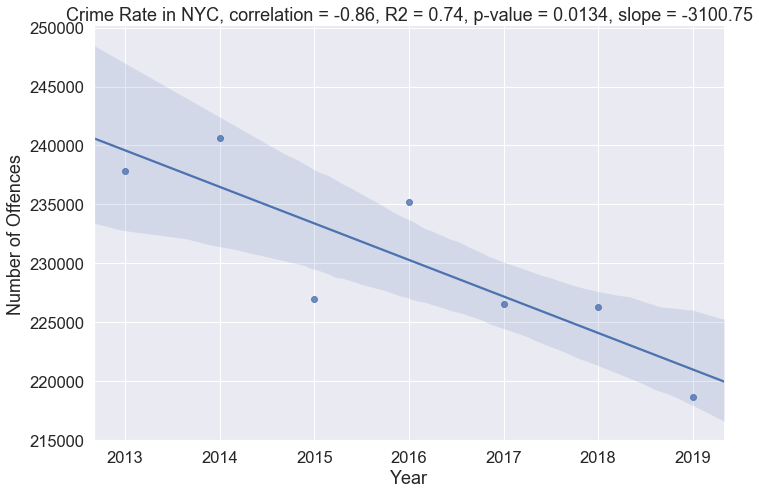

In [120]:
crimeCountByYear(df_count_by_year_cid)

Note - The blue dots represent the crime number and the line represents the crime rate  
<b>Inference</b> - 
1. There is a steady drop in crime rate from years 2013 - 2018. 
2. Approximately crime rate drops by roughly 7000 crimes per year.

### Analysing crime rate across boroughs in New York

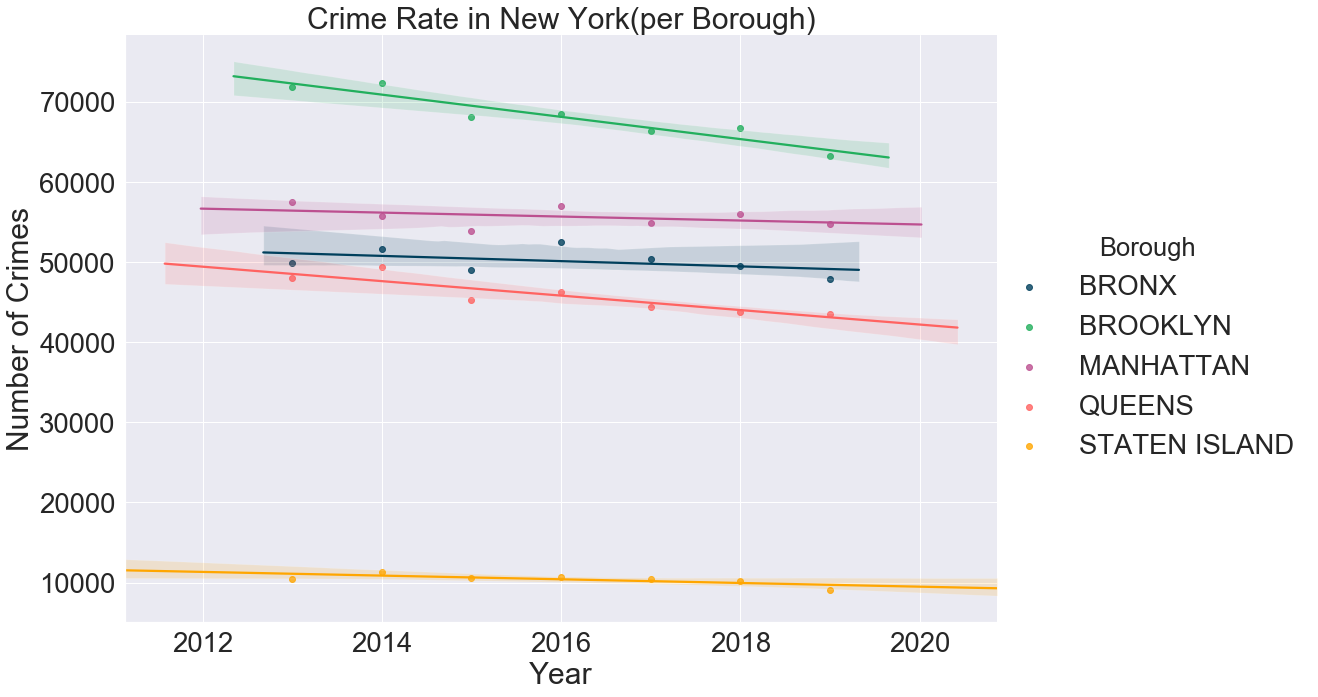

In [50]:
def crimeCountByBorough(df_count_by_year_borough_cid):
    '''
    Plot to count crime rate depending on number of crimes per borough
    @params - dataframe grouped by number of crimes per borough
    '''
    flatui = ["#003f5c", "#22af5d", "#bc5090", "#ff6361", "#ffa600", "#3ecc71"]
    sns.set(font_scale = 2)
    tplot = sns.lmplot(x = 'Year', y = 'ComplaintID', data = df_count_by_year_borough_cid, hue = 'Borough',palette = flatui, height = 10, aspect = 1.5)
    tplot = (tplot.set_axis_labels("Year","Number of Crimes"))
    plt.title("Crime Rate in New York(per Borough)")    
crimeCountByBorough(df_count_by_year_borough_cid)

<b>Inference</b> - 
1. The crime rate drops steadily in all the boroughs with fastest drop in <b><i>Brooklyn</i></b> and slowest drop in <b><i>Staten Island</i></b>
2. Crime rate depending on <b><i>number of offence</i></b> isn't the best indicator to compare crimes in Boroughs as the boroughs differ significantly in the areas.

In [122]:
#mapper function that maps value for given column name
def valfunc(row, val_dict, column):
    '''
    val_dict - dictionary with names and values
    column - column name with names
    return value for given column name
    '''
    return val_dict[row[column]]

### Analysing crime density per borough across years in New York

Number of offences was a problem in earlier part. Hence, if we spread same number of offences over larger area, there will be less imbalance in the data. Hence we use crime density.


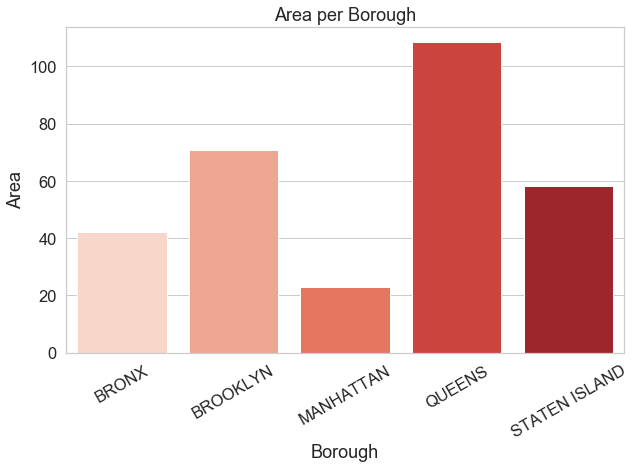

In [121]:
def areaPerBorough():
    '''
    Plot size of area per borough
    '''
    sns.set_style('whitegrid')
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    g = sns.barplot(x = 'Borough', y = 'Area', data = df_count_by_year_borough_cid, palette = 'Reds')
    plt.ylabel('Area')
    plt.title("Area per Borough")
    plt.xticks(rotation=30)
areaPerBorough()

The above graph clearly shows that <b>Queens has area size almost 5 times greater than Manhattan</b>  
Hence, we use crime density instead of number of offences.

In [153]:
def numberCrimesPerBorough(dataframe):
    '''
    plot number of crimes per borough
    @params: dataframe
    '''
    sns.set_style('whitegrid')
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    g = sns.barplot(x = 'Borough', y = 'ComplaintID', data = dataframe, palette = 'YlGnBu') #creating bar plot with x as boroughs and y as complaintId
    plt.ylabel('Number of Offences')
    plt.title("Number of Offences per Borough")
    
def crimeDensityPerBorough(df_crime_per_borough):
    '''
    calculate crime density per borough
    @params: dataframe
    @return: dataframe with added files of Area and CrimeDensity
    '''
    
    #seggregate areas by the boroughs
    df_crime_per_borough["Area"] = df_crime_per_borough.apply(valfunc, val_dict = boroughs_area, column = 'Borough', axis = 1)
    
    #calculate crimedensity - number of crimes / area
    df_crime_per_borough["CrimeDensity"] = df_crime_per_borough.ComplaintID / df_crime_per_borough.Area
    
    #display(df_count_by_year_borough_cid["CrimeDensity"]) #logging
    return df_crime_per_borough

df_crime_density_per_borough = df_count_by_year_borough_cid.copy() #to avoid the pass by reference, copy() is used.
df_crime_density_per_borough = crimeDensityPerBorough(df_crime_density_borough)
    
def crimeDensityPerBoroughPlot(dataframe):
    '''
    @params: plot crime density per borough
    '''
    sns.set_style('whitegrid')
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    g = sns.barplot(x = 'Borough',y = 'CrimeDensity', data = dataframe, palette = 'YlGnBu')
    plt.ylabel('Crime Density')
    plt.title("Crime Density Per Borough")

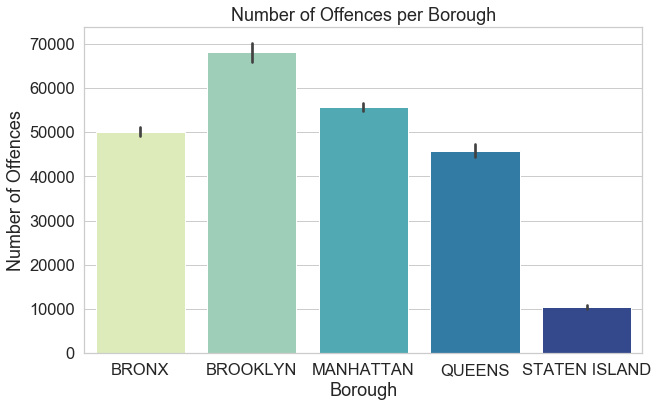

In [154]:
numberCrimesPerBorough(df_crime_density_per_borough)

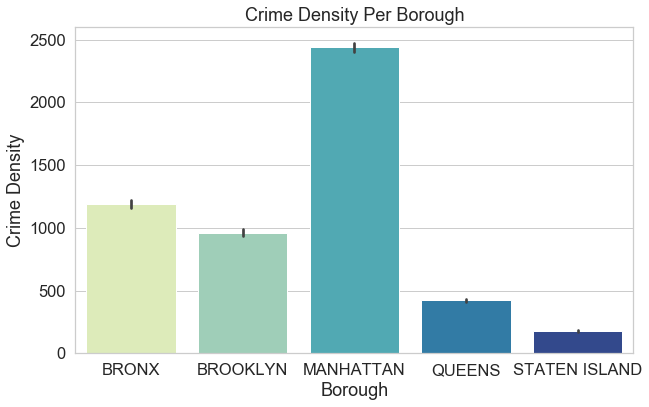

In [155]:
crimeDensityPerBoroughPlot(df_crime_density_per_borough)

<b>Inferences -</b>
1. According to number of offences, Brooklyn has the highest number of crimes.  
However, according to crime density, Manhattan has the highest crime density.
2. More denser the crimes in a borough, the more number of crimes can be expected in their respective neighbourhoods 

### Analysing crime density and number of crimes with heatmaps

In [141]:
#geoplotting function
def map_points(df, lat_col='latitude', lon_col='longitude', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """
    Creates a map given a dataframe of points.
    @params:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    @return:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].as_matrix().tolist()
        curr_map.add_child(plugins.HeatMap(stations, radius=heat_map_radius))
    return curr_map

df_pickle_cleaned = pd.read_pickle('NYPD_Complaint_Data_Cleaned')
df_pickle_cleaned = df_pickle_cleaned.groupby("Neighborhood")[['latitude','longitude','ComplaintID']].agg({'latitude':'mean','longitude':'mean','ComplaintID':'count'})

In [146]:
#plotting heat map for dataframe and plotting number of complaints per Neighborhood
map_points(df_pickle_cleaned, lat_col ='latitude', lon_col = 'longitude', zoom_start = 10, plot_points = False, pt_radius = 12, draw_heatmap = True, heat_map_weights_col = 'ComplaintID', heat_map_weights_normalize = True, heat_map_radius = 13)

<b>Inferences -</b>
1. From the above plot, we can see that the borough <b><i>Manhattan</i></b> has the highest intensity on heatmaps
2. Similarly we can observer for Staten Island, its very less

The intensity is given by: yellow > green > blue >  purple (in decreasing order of intensity)

### Analysing crime density with population

Crime density can also depend on population. Greater the population, the likelihood of crime is generally higher.  
Lets see what impact the population in New York has on crime density

<b>Note:</b> The population of each borough in New York is referenced from [here](https://www.citypopulation.de/en/usa/newyorkcity/)

In [148]:
def crimeDensityPer1000Citizens(df_crime_density_per_borough):
    '''
    calculate crime density per 1000 citizens and store it in df.
    @params: dataframe
    @return: dataframe with added fields such as population, pop_frac, crime_frac, area_frac and crime rate
    '''
    
    df_population = df_crime_density_per_borough.copy() #not making changes to original data
    boroughs_population = {"BROOKLYN":2582830.0, "BRONX":1432132.0, "QUEENS":2278906.0, "MANHATTAN":1628701.0, "STATEN ISLAND":476179.0}
    df_population['Population'] = df_population.apply(valfunc, val_dict = boroughs_population, column = 'Borough', axis = 1)#populating population 

    #calculating total population, crime number, area
    pop_sum = sum(df_population.Population)
    crime_sum = sum(df_population.ComplaintID)
    area_sum = sum(df_population.Area)

    #calculating different fractions(population, crime, area)
    df_population['Pop_frac']=df_population.Population / pop_sum
    df_population['Crime_frac']=df_population.ComplaintID / crime_sum
    df_population['Area_frac']=df_population.Area / area_sum
    
    #number of crimes recorded on average per 1000 citizens
    df_population['CrimeRatePer1000Citzens'] = df_population.ComplaintID / df_population.Population * 1000
    display(df_population.head())
    
    return df_population

df_population = crimeDensityPer1000Citizens(df_crime_density_per_borough)

,Year,Borough,ComplaintID,Area,CrimeDensity,Population,Pop_frac,Crime_frac,Area_frac,CrimeRatePer1000Citzens
0,2013,BRONX,49941,42.10,1186.247031,1432132.0,0.024360,0.031001,0.019874,34.871786
1,2013,BROOKLYN,71836,70.82,1014.346230,2582830.0,0.043932,0.044593,0.033432,27.812903
2,2013,MANHATTAN,57515,22.83,2519.272887,1628701.0,0.027703,0.035703,0.010777,35.313418
3,2013,QUEENS,47951,108.50,441.944700,2278906.0,0.038763,0.029766,0.051219,21.041236
4,2013,STATEN ISLAND,10453,58.37,179.081720,476179.0,0.008099,0.006489,0.027555,21.951829


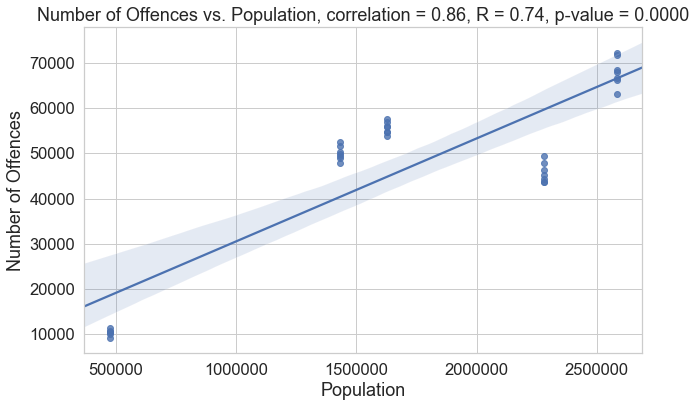

In [156]:
def noOfOffencesVsPopulationPlot(df_population):
    '''
    @params: dataframe
    plotting relationship between borough population and number of crimes
    '''
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_population.Population, df_population.ComplaintID)
    #print("R value is {}, p - value is {} , slope is {}".format(rvalue,pvalue,slope))
    sns.set_style('whitegrid')
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    g = sns.regplot(x = 'Population',y = 'ComplaintID',data = df_population)
    plt.ylabel('Number of Offences')
    plt.title("Number of Offences vs. Population, correlation = {:.2f}, R = {:.2f}, p-value = {:.4f}".format(rvalue,rvalue**2,pvalue));
    plt.show()
noOfOffencesVsPopulationPlot(df_population)

<b>Inference -</b> The plot compares the number of offences against the population. It is evident that there is a strong positive correlation (86%) among both the attributes.  
So our initial assumption of <b> > the population, > the crime rate</b> holds true with New York as well.  

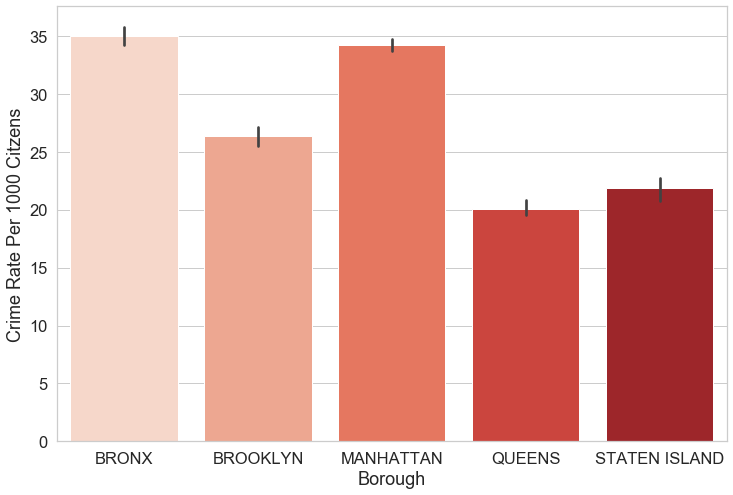

In [158]:
def crimeRatePer1000CitizensPlot():
    '''
    plotting crime rate per 1000 citizens
    '''
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    g = sns.barplot(x = 'Borough',y = 'CrimeRatePer1000Citzens', data = df_population, palette = 'Reds')
    plt.ylabel('Crime Rate Per 1000 Citzens')
    plt.show()
    
crimeRatePer1000CitizensPlot()

<b>Inference -</b> 
The above plot shows number of crimes on average among 1000 citizens. We can see that <b><i>Bronx</b></i> closely followed by <b><i>Manhattan</i></b> has highest reported crimes per 1000 citizens.

### Summarizing differences between Boroughs wrt Crime Rates, Population and Areas
Here we compare population fraction across Boroughs with the influence of area fraction and crime fraction 

In [163]:
def compareDifferentFractions(df_population):
    '''
    creating df structure to plot fractions
    @params: dataframe
    @return: unpivoted dataframe with id_var as Borough
    '''
    df_fractions = df_population[['Borough','Pop_frac','Crime_frac','Area_frac']] #pick appropriate columns for comparison
    df_fractions = df_fractions.rename(columns = {'Pop_frac':"Population Fraction", "Crime_frac":'Crime Fraction', "Area_frac":'Area Fraction'}) #rename column for names on plot
    df_fractions = df_fractions.melt(id_vars = "Borough",var_name = "Fraction") #massage the df_fractions into a format having column "Boroughs" as identifier variable.. 
    df_fractions.head()
    return df_fractions

df_fractions = compareDifferentFractions(df_population)

def fractionsPlot(): 
    '''
    plot crime homogenity
    '''
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    sns.set_style('whitegrid')
    sns.barplot(x='Borough',y='value',hue = 'Fraction', data=df_fractions)
    plt.ylabel('Number of Crimes')
    plt.title("Crime Homogeneity")
    plt.show()

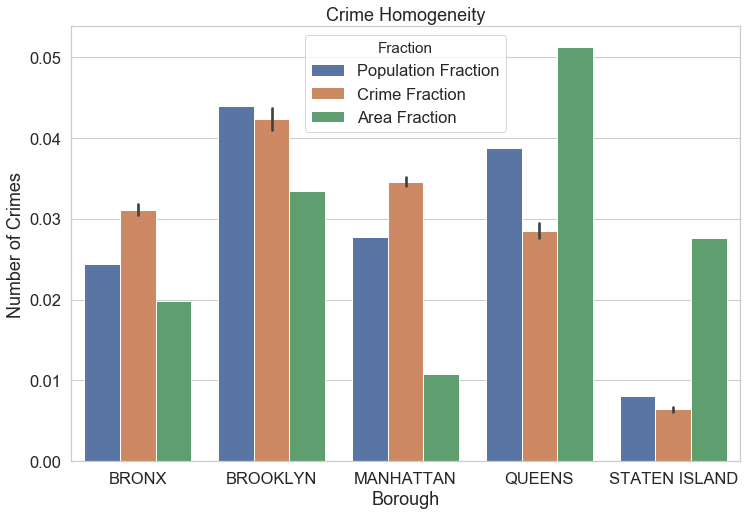

In [164]:
fractionsPlot()

<b>Inferences - </b>
1. <b><i>Bronx</i></b> and <b><i>Manhattan</i></b> both have higher fraction of crime than population and area fraction
2. <b><i>Queens</i></b> and <b><i>Staten Island</i></b> had lowest number of crime fraction in comparison with population and area
3. The fractions for <b><i>Manhattan</i></b> and <b><i>Queens</i></b> <u>area</u> are disproportionately higher or lower than other two fractions

### Analysing crime status across different boroughs
There are 3 different types of crimes -
1. Felony : serious crime involving voilence. Usually punishable by imprisonment for more than a year or by death. Example - robbery, felony assault, burglary etc.
2. Misdemeanor : minor crime / wrongdoing. Example - larceny, criminal mischief or dangerous drugs.
3. Violation : includes offence like harassment, disorderly conduct, loitering etc.

1 > 2 > 3 in terms of seriousness in crimes.

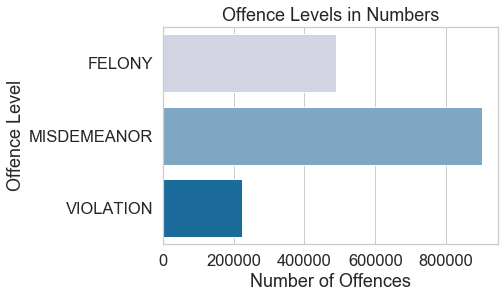

In [183]:
def crimeOffenceLevel(dfHplusY_clean_load):
    '''
    create dataframe to calculate offence level
    @params: dataframe
    @return: tuple containing dataframe 
    '''
    df_offence_cid = dfHplusY_clean_load.groupby(['Offence Level'])['ComplaintID'].count().reset_index() #groupby offencelevel and get the counts as per complaintid
    df_year_offence_cid = dfHplusY_clean_load.groupby(['Year','Offence Level'])['ComplaintID'].count().reset_index() #groupby year and offence level and get counts as per complaintid
    return (df_offence_cid, df_year_offence_cid)

df_offence_cid, df_year_offence_cid = crimeOffenceLevel(dfHplusY_clean_load)


def crimeOffenceLevelPlot(dataframe):
    '''
    plot number of offences per offence level
    @params: dataframe 
    '''
    sns.set_style('whitegrid')
    g = sns.barplot(x = 'ComplaintID', y = 'Offence Level',data = dataframe, palette = 'PuBu')
    plt.xlabel('Number of Offences')
    plt.title("Offence Levels in Numbers")
crimeOffenceLevelPlot(df_offence_cid)

<b>Inference -</b>  
<b><i>Misdemeanor</i></b> is the most reported crime and its almost 2 times that of <b><i>Felony</i></b>. It is approximately 5 times that of <b><i>Violation</i></b>


In [201]:
def crimeOffenceLevelPerBorough(dfHplusY_clean_load):
    '''
    calculate crime offence level per borough
    @params: dataframe
    @return: modified dataframe
    '''
    df_crime_status_borough = dfHplusY_clean_load.groupby(['Borough','Offence Level'])['ComplaintID'].count().reset_index()
    df_crime_status_borough['Area'] = df_crime_status_borough.apply(valfunc, val_dict=boroughs_area, column='Borough', axis=1)
    df_crime_status_borough['CrimeDensity'] = df_crime_status_borough.ComplaintID/df_crime_status_borough.Area
    return df_crime_status_borough

df_crime_status_borough = crimeOffenceLevelPerBorough(dfHplusY_clean_load)
display(df_crime_status_borough)

def crimeOffenceLevelPerBoroughPlot(df_crime_status_borough):
    #plotting number of offences per level per borough
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    sns.set_style('whitegrid')
    g=sns.barplot(x = "Borough", y = 'CrimeDensity', hue = 'Offence Level', data = df_crime_status_borough)
    plt.ylabel('Crime Density')
    plt.title("Offence Levels")

,Borough,Offence Level,ComplaintID,Area,CrimeDensity
0,BRONX,FELONY,94370,42.10,2241.567696
1,BRONX,MISDEMEANOR,206833,42.10,4912.897862
2,BRONX,VIOLATION,49600,42.10,1178.147268
3,BROOKLYN,FELONY,153807,70.82,2171.801751
4,BROOKLYN,MISDEMEANOR,255856,70.82,3612.764756
5,BROOKLYN,VIOLATION,67214,70.82,949.082180
6,MANHATTAN,FELONY,118313,22.83,5182.347788
7,MANHATTAN,MISDEMEANOR,226376,22.83,9915.724923
8,MANHATTAN,VIOLATION,45065,22.83,1973.937801
9,QUEENS,FELONY,103859,108.50,957.225806


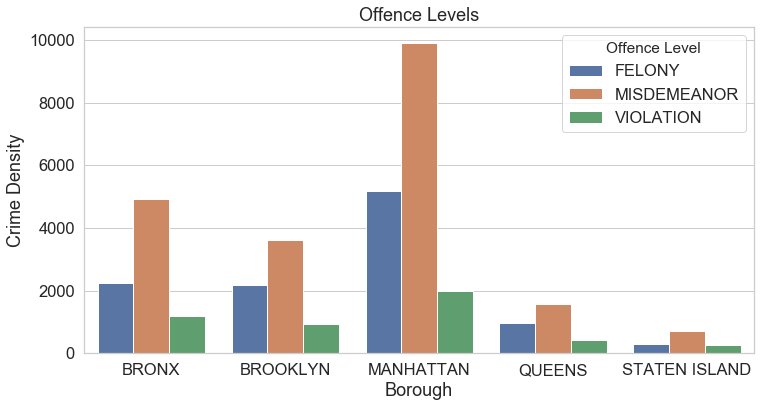

In [202]:
crimeOffenceLevelPerBoroughPlot(df_crime_status_borough)

<b>Inference-</b>
1. Here, the distribution of different level crimes is similar in all three boroughs and follows general trend that
<b><i>Misdemeanors</i></b> are almost twice more frequent that <b><i>Felony</i></b> and around five times more frequent than <b><i>Violations</i></b>. 
2. <b><i>Manhattan</i></b> has the highest density of all three offence types whereas <b><i>Staten Island</b></i> has the lowest

###  Analysing number of criminal offences according to month and time

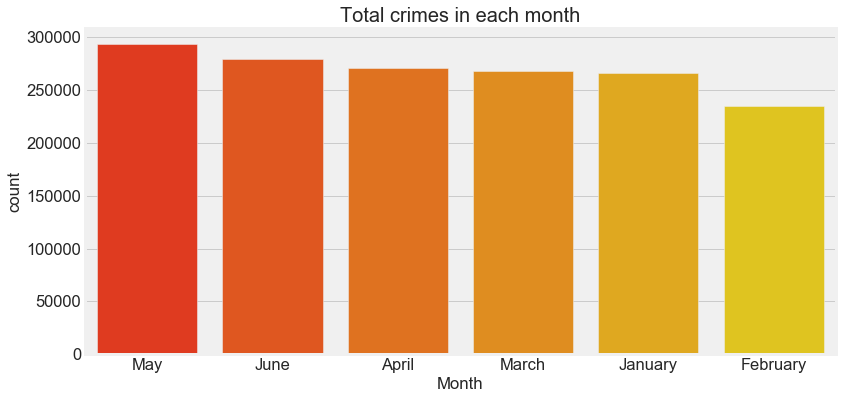

In [309]:
def countCrimeByMonths(dfHplusY_clean_load):
    '''
    Count crime by months
    @params: dataframe
    '''
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    plt.style.use('fivethirtyeight')
    g = sns.countplot(dfHplusY_clean_load['Month'], palette = 'autumn', order = dfHplusY_clean_load['Month'].value_counts().index)
    plt.title('Total crimes in each month', fontsize = 20)
    g.set(xticklabels=['May', 'June', 'April', 'March', 'January', "February"])
    plt.show()
countCrimeByMonths(dfHplusY_clean_load)

In [310]:
def top15HoursOfCriminalOffences(dfHplusY_clean_load):
    '''
    Defines top 20 hours when crime was committed
    @params: dataframe
    '''
    #fig = plt.gcf()
    #fig.set_size_inches(12, 6)
    sns.set_style('whitegrid')
    color = cm.inferno_r(np.linspace(.4, .8, 30))
    dfHplusY_clean_load['Time'].value_counts().head(15).plot.bar(color = color, figsize = (12, 6))
    plt.title('Top 15 hours of most criminal activity', fontsize = 20)
    plt.xlabel("Hours", fontsize = 20)
    plt.ylabel("Number of Offences", fontsize = 20)
    plt.show()

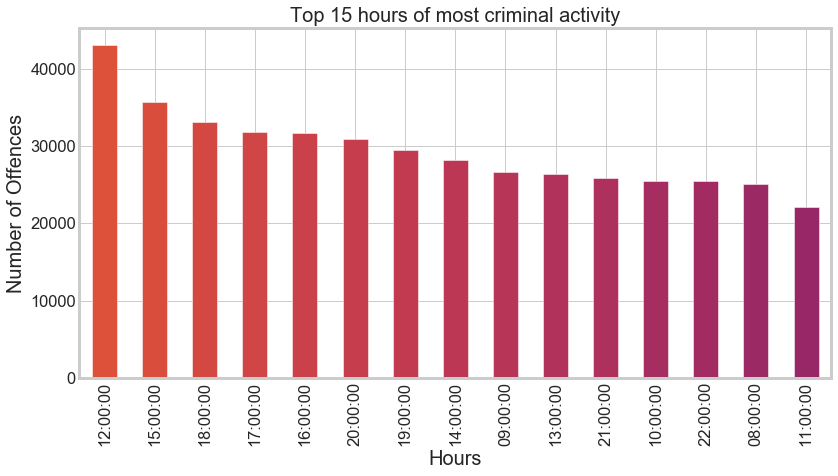

In [311]:
top15HoursOfCriminalOffences(dfHplusY_clean_load)

<b>Inference</b>- May was the month that recorded most number of crimes and from the top 15 hours, 12pm noon was the time that observed most crimes

### Understanding similarities between boroughs

In [351]:
def find_similarities(df):
    '''
    Construct similarity matrix between boroughs for crime offences with the help of offence code
    @params: dataframe
    @return: dataframe with modified neighborhood
    '''
    def create_similarity_matrix(df_normalised):    
        '''
        #generate similarity matrix
        The borough vectors are created through summation of precinct vectors belonging to each borough.
        Cosine products of the borough vectors are calculated for each pair of the boroughs.
        @params: normalised dataframe
        @return: similarity matrix
        '''
        
        boroughs  = ['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND']
        sim_dict = {}
        for borough in boroughs : #loop over the boroughs list
            current_borough = df_normalised.loc[borough]
            similarities = dfnorm.dot(current_borough) 
            sim_dict[borough]=similarities #append the similarity vector to the sim_dict with key as borough
            #print(similarities.nlargest())
        simdf = pd.DataFrame(sim_dict, index = boroughslst) #similarity_df
        display(simdf)
        return simdf
    
    df_similarity_boroughs = df[['Offence Code','Borough','Neighborhood','Description','Offence Level']].reset_index() #get subset of dataframe
    df_similarity_boroughs.dropna(subset = ['Neighborhood'],inplace = True) #remove null records if any and pick only one subset
    df_similarity_boroughs["Neighborhood"] = df_similarity_boroughs.Neighborhood.astype('int') #mapping the existing data of Neighborhood to integers
    df_similarity_boroughs['value'] = 1 # setting value 1 of occurence of the offence code in the Precinct 
    df_similarity_boroughs_ = df_similarity_boroughs.pivot_table(index=df_similarity_boroughs.index, columns = 'Borough',values ='value',aggfunc = 'sum')
    df_similarity_boroughs_['Offence Code'] = df_similarity_boroughs['Offence Code']
    df_similarity_boroughs_by_offence = df_similarity_boroughs_.groupby('Offence Code').sum() #groupby offence code and then perform sum
    df_similarity_boroughs_by_offence_pivoted = df_similarity_boroughs_by_offence.pivot_table(columns = "Offence Code") #spreadsheet style pivot table
    
    norm = normalize(df_similarity_boroughs_by_offence_pivoted, axis = 1) #normalize the df row wise
    dfnorm = pd.DataFrame(norm, index = ["BRONX",'BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND'] ) #convert the normalized matrix back to dataframe
    return create_similarity_matrix(dfnorm) 
simdf = find_similarities(dfHplusY_clean_load)

,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
BRONX,1.000000,0.982459,0.913186,0.966564,0.954348
BROOKLYN,0.982459,1.000000,0.952741,0.994095,0.962311
MANHATTAN,0.913186,0.952741,1.000000,0.947231,0.880003
QUEENS,0.966564,0.994095,0.947231,1.000000,0.962788
STATEN ISLAND,0.954348,0.962311,0.880003,0.962788,1.000000


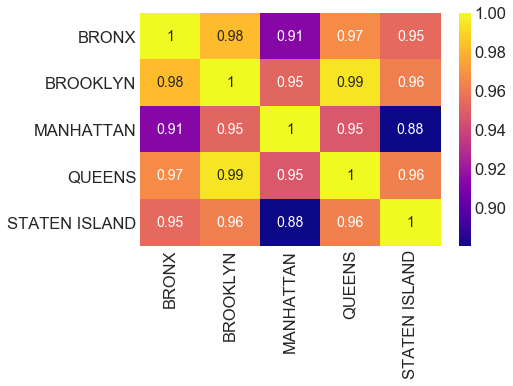

In [352]:
def findCosineSimilarity(simdf):
    ax = sns.heatmap(simdf, annot=True, cmap = 'plasma') #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
findCosineSimilarity(simdf)

<b>Inferences</b>-
1. Brooklyn and Queens are closest in similarity in both the directions.
2. Bronx and Manhattan are also most similar to Brooklyn, however Manhattan differs the most from other boroughs.
3. Staten Island resembles almost equal scores to that of Brooklyn and Queens
4. Manhattan and Staten Islands differ from most of the boroughs.


## Conclusion

* The most challenging part for this project was data collection phase. It took alot of thinking to tune the API calls in a way that it can collect data in chunks which can be combined later into a single unit for processing.
* Extensive data pre-processing was required to get the data in right format that was necessary for further analysis.
* In the end, I was able to find inferences for each analysis that I performed.
* Crime analysis of NYC was performed primarily using the NYPD dataset. Generally the number of recorded crimes decreased each year. 
* Area of Boroughs was a crucial factor in this analysis which made me change my metric from number of crime offences to crime density. Crime density helped me get better results for crime rate per borough.
* There are significant differences between boroughs in terms of population as well. Crime rate per 1000 citizens helped in identifying which borough was safest to live.
* Time and months were also selected as attributes to identify the hour and months with most crimes.
* There are alot of similarities between boroughs in terms of crime rate patterns. From the heatmaps in the end I could generate similarities in crime ates between boroughs and also identify those boroughs that were totally dissimilar.
